In [1]:
pip install tensorflow matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set directories
base_dir = "./images/genderData"
train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

# Hyperparameters
img_size = (224, 224)
batch_size = 32
epochs = 50
checkpoint_path = "./models/gender/gender_best_model.keras"

# Data Augmentation and Generators
train_datagen = ImageDataGenerator(rescale=1.0 / 255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode="binary"
)

validation_generator = val_test_datagen.flow_from_directory(
    validation_dir, target_size=img_size, batch_size=batch_size, class_mode="binary"
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=1, class_mode="binary", shuffle=False
)

Found 39200 images belonging to 2 classes.
Found 11200 images belonging to 2 classes.
Found 5600 images belonging to 2 classes.


In [3]:
# Load from checkpoint if exists
if os.path.exists(checkpoint_path):
    print("Resuming from saved checkpoint...")
    model = tf.keras.models.load_model(checkpoint_path)
else:
    print("Starting fresh training...")
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", input_shape=(img_size[0], img_size[1], 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation="relu"),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation="relu"),
        Dropout(0.5),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Checkpoint callback
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

Starting fresh training...


c:\Users\intel\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
# Training
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[checkpoint_cb]
)


c:\Users\intel\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6703 - loss: 0.6006
Epoch 1: val_accuracy improved from -inf to 0.85098, saving model to ./models/gender/gender_best_model.keras
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 2081s 2s/step - accuracy: 0.6704 - loss: 0.6006 - val_accuracy: 0.8510 - val_loss: 0.3502
Epoch 2/50
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8229 - loss: 0.4052
Epoch 2: val_accuracy improved from 0.85098 to 0.88384, saving model to ./models/gender/gender_best_model.keras
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 1464s 1s/step - accuracy: 0.8229 - loss: 0.4052 - val_accuracy: 0.8838 - val_loss: 0.2761
Epoch 3/50
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8606 - loss: 0.3292
Epoch 3: val_accuracy improved from 0.88384 to 0.91205, saving model to ./models/gender/gender_best_model.keras
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 2080s 2s/step - accuracy: 0.8606 - loss: 0.3292 - val_accuracy: 0.9121 - val_loss: 0.2170
Epoch 4/50
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 0

In [5]:
# Load best model
model = tf.keras.models.load_model(checkpoint_path)

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")

5600/5600 ━━━━━━━━━━━━━━━━━━━━ 115s 20ms/step - accuracy: 0.9383 - loss: 0.1996
Test Accuracy: 0.94


5600/5600 ━━━━━━━━━━━━━━━━━━━━ 76s 13ms/step


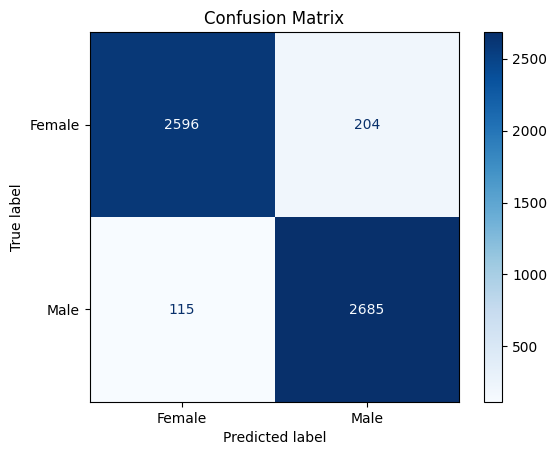

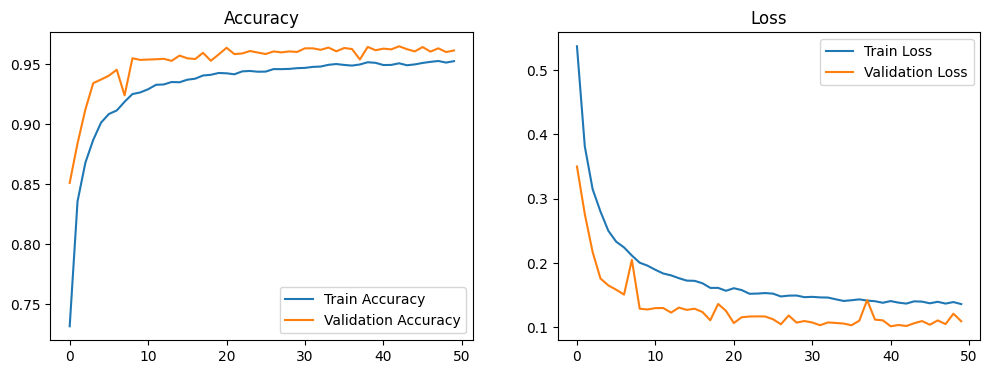

In [6]:
# Confusion Matrix
y_true = test_generator.classes
y_pred = (model.predict(test_generator) > 0.5).astype("int").reshape(-1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Female", "Male"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Plot Accuracy & Loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.legend()

plt.show()

In [7]:
# Test with a single image
def test_single_image(image_path):
    image = load_img(image_path, target_size=img_size)
    image_array = img_to_array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)

    prediction = model.predict(image_array)[0][0]
    label = "Male" if prediction > 0.5 else "Female"

    plt.imshow(image)
    plt.title(f"Predicted: {label} ({prediction:.2f})")
    plt.axis("off")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


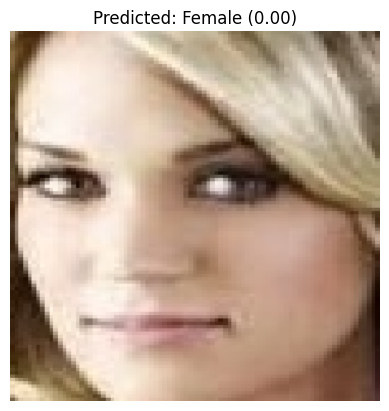

In [13]:
# Example test image
test_single_image("images/genderData/test/female/130737.jpg.jpg")

In [9]:

# Save the final model
model.save("./models/new_gender_classifier.h5")